PREVISÃO DE GASTOS COM SEGURO
=============================

## Imports

In [1]:
# Base
import pandas as pd
import numpy as np
from scipy import stats
import math

# Plot
from matplotlib import pyplot as plt 
import seaborn as sns

# ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, \
    mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Others
import warnings
warnings.filterwarnings("ignore")

## Configs

In [27]:
PLOT_MEDIUM = (8,8)
PLOT_WIDE = (14,7)
sns.set_style('darkgrid')

## Carregamento de dados

In [3]:
data = pd.read_csv('./../../../Datasets/insurance.csv')

In [4]:
display(data.shape, data.head())  

(1338, 7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Explorar e visualizar os dados para entender suas características

In [5]:
# Tipos de dados
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
# Descrição dos dados numéricos
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# Missing values
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
# Duplicates
data.drop_duplicates(keep='first', inplace=True)

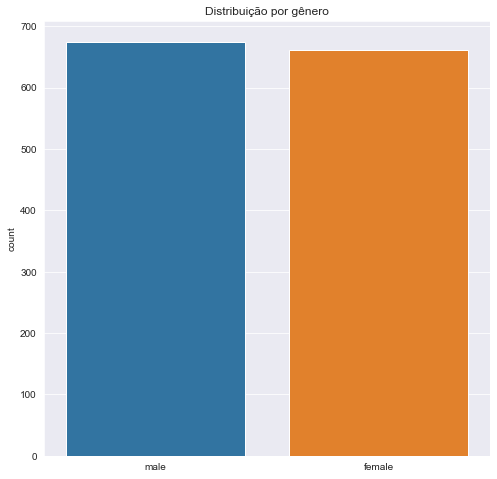

In [9]:
plt.figure(figsize=PLOT_MEDIUM)
sns.barplot(None, x=['male', 'female'], y=data.sex.value_counts())
plt.title('Distribuição por gênero')
plt.show()

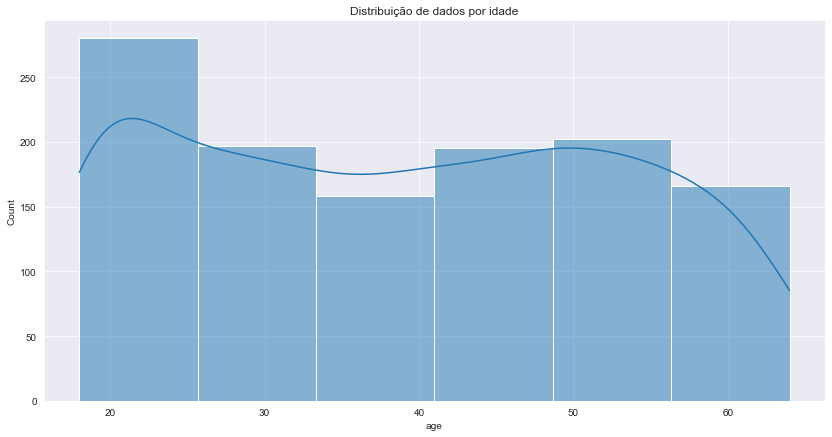

In [28]:
# Distribuição por idade

plt.figure(figsize=PLOT_WIDE)
sns.histplot(data['age'], bins=6, kde=True)
plt.title("Distribuição de dados por idade")
plt.show()

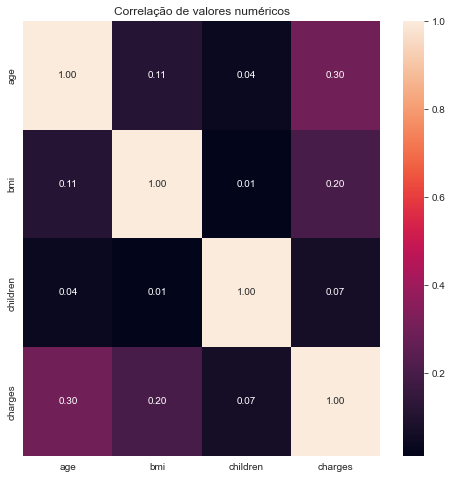

In [11]:
# sem correlação entre dados numéricos
matrix_corr = data.select_dtypes(['float', 'int']).corr()
matrix_corr

plt.figure(figsize=PLOT_MEDIUM)
sns.heatmap(matrix_corr, annot=True, fmt='.2f')
plt.title("Correlação de valores numéricos")
plt.show()

In [12]:
# comprar dados não numéricos também
data.columns


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

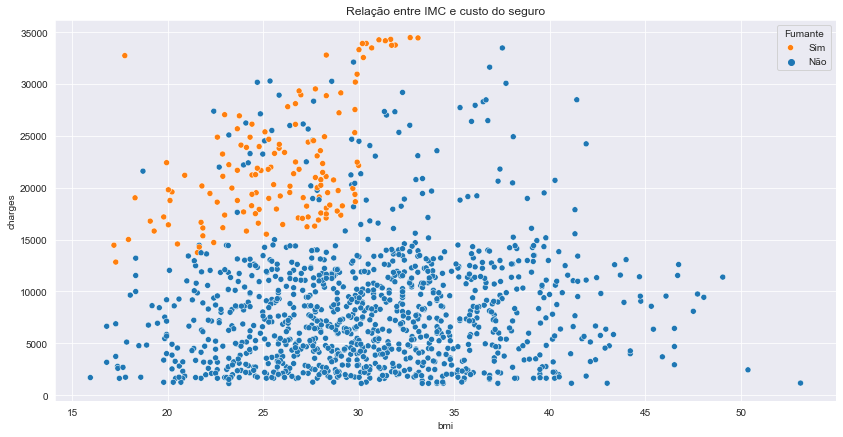

In [31]:
# imc
plt.figure(figsize=PLOT_WIDE)
sns.scatterplot(data, x='bmi', y='charges', hue='smoker')
plt.title("Relação entre IMC e custo do seguro")
plt.legend(title='Fumante', labels=['Sim', 'Não'])
plt.show()

# fumantes pagam valores mais altos, porêm são mais magros!

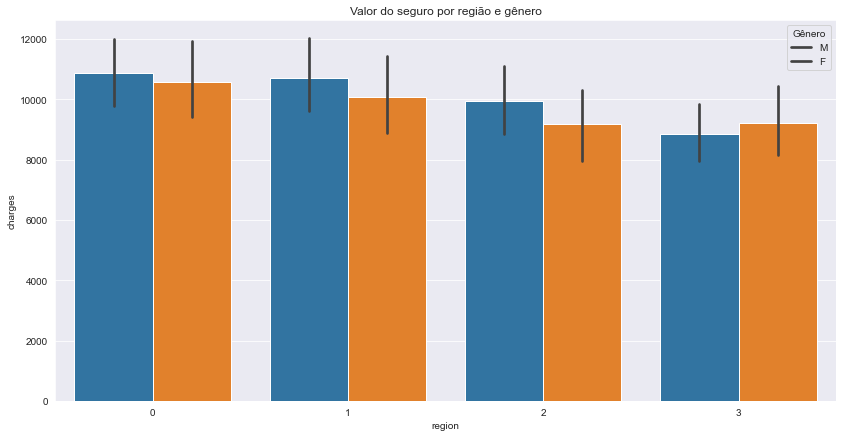

In [32]:
plt.figure(figsize=PLOT_WIDE)
sns.barplot(data, x='region', y='charges', hue='sex')
plt.title("Valor do seguro por região e gênero")
plt.legend(title='Gênero', labels=['M', 'F'])
plt.show()

# no sudeste e sudoeste, mulheres pagam - em média - mais que homens, \
# porém aparentemente não há diferenças significativas entre as regiões

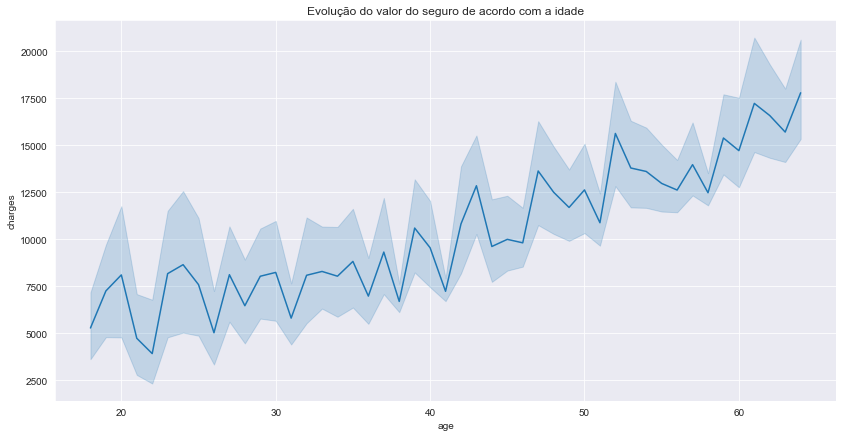

In [33]:
plt.figure(figsize=PLOT_WIDE)
sns.lineplot(data, x='age', y='charges')
plt.title("Evolução do valor do seguro de acordo com a idade")
plt.show()

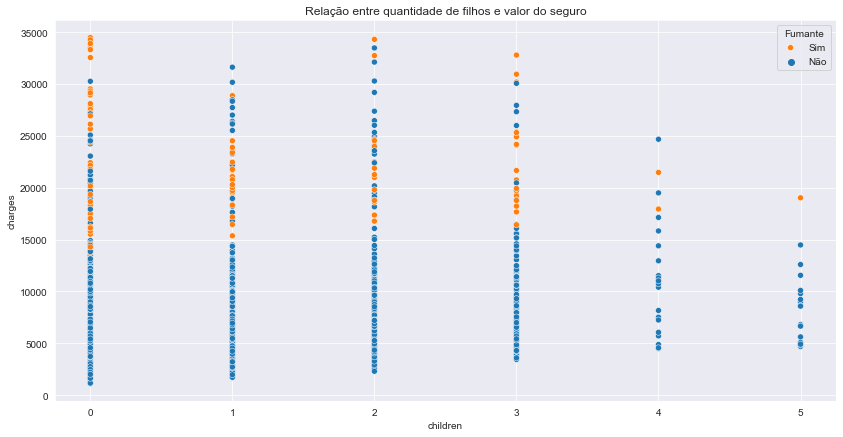

In [35]:

# Relação entre quantidade de filhos (children) e valor do seguro (charges)
# Aparentemente, após o 4to filho o valor do seguro diminui consideravelmente

# Aparentemente, fumantes pagam mais do que não fumantes

plt.figure(figsize=PLOT_WIDE)
sns.scatterplot(data, x='children', y='charges', hue='smoker')
plt.title("Relação entre quantidade de filhos e valor do seguro")
plt.legend(title='Fumante', labels=['Sim', 'Não'])
plt.show()

In [39]:
# calcular percentual de diff entre pagamento de seguro até 4 filhos e >4

more_than_4_children = data[data['children'] >= 4]['charges'].mean()
less_than_4_children = data[data['children'] < 4]['charges'].mean()

print("Média de pagamentos com 4 filhos ou mais: {:,.2f}".format(more_than_4_children))
print("Média de pagamentos com menos de 4 filhos: {:,.2f}".format(less_than_4_children))
print("Diferença: {:,.2f}%".format((more_than_4_children/less_than_4_children-1)*100))

# Podemos afirmar que existe uma diferença considerável entre esses valores? 

Média de pagamentos com 4 filhos ou mais: 10,430.55
Média de pagamentos com menos de 4 filhos: 9,917.10
Diferença: 5.18%


Média de pagamentos dos fumantes: 22,014.25
Média de pagamentos com menos de 4 filhos: 8,362.05
Diferença: 163.26%


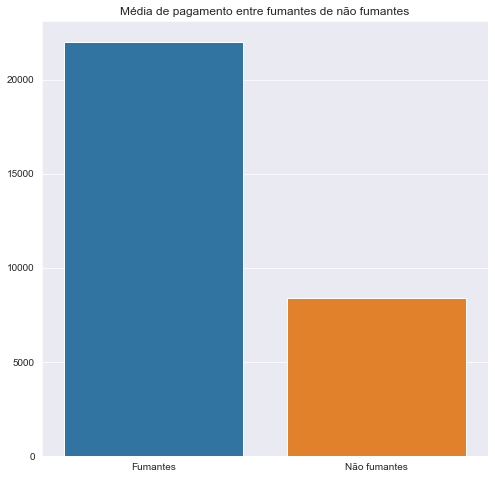

In [40]:
# Estabelecer percentual entre valor de pagamento de fumantes e não fumantes
fumantes = data[data['smoker'] == 1]['charges'].mean()
nao_fumantes = data[data['smoker'] == 0]['charges'].mean()

print("Média de pagamentos dos fumantes: {:,.2f}".format(fumantes))
print("Média de pagamentos com menos de 4 filhos: {:,.2f}".format(nao_fumantes))
print("Diferença: {:,.2f}%".format((fumantes/nao_fumantes-1)*100))

plt.figure(figsize=PLOT_MEDIUM)
sns.barplot(None, x=['Fumantes', 'Não fumantes'], y=[fumantes, nao_fumantes])
plt.title("Média de pagamento entre fumantes de não fumantes")
plt.show()

### 3. Divida os dados em recursos (X) e rótulos (y).

In [41]:
encoder = LabelEncoder()
for col in data.select_dtypes('object').columns:
    data[col] = encoder.fit_transform(data[col])

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [42]:

def remove_outliers_iqr(df, threshold=1.5):
    for column_name in df.columns:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_cleaned = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    print(df.shape)
    print(df_cleaned.shape)
    return df_cleaned

In [43]:
data = remove_outliers_iqr(data)

(1198, 7)
(1143, 7)


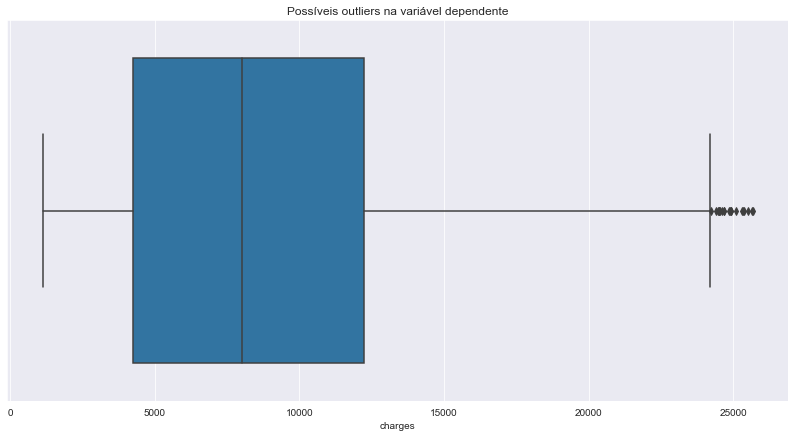

In [48]:
plt.figure(figsize=PLOT_WIDE)
sns.boxplot(x=data['charges'])
plt.title("Possíveis outliers na variável dependente")
plt.show()

In [23]:
y = data['charges']
X = data.drop('charges', axis=1)

(   age  sex     bmi  children  smoker  region
 0   19    0  27.900         0       1       3
 1   18    1  33.770         1       0       2
 2   28    1  33.000         3       0       2
 3   33    1  22.705         0       0       1
 4   32    1  28.880         0       0       1,
 0    16884.92400
 1     1725.55230
 2     4449.46200
 3    21984.47061
 4     3866.85520
 Name: charges, dtype: float64)

### 4. Divida o conjunto de dados em conjuntos de treinamento e teste.

In [68]:
def results(y_test_, y_pred_, show=True):
    mse = mean_squared_error(y_test_, y_pred_)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_, y_pred_)
    mape = mean_absolute_percentage_error(y_test_, y_pred_)
    r2 = r2_score(y_test_, y_pred_)
    
    if show:
        print(f"MSE = {mse}")
        print(f"RMSE = {rmse}")
        print(f"MAE = {mae}")
        print(f"MAPE = {mape}")
        print(f"R2 = {r2}")

    return r2

def compute_regression(X_, y_, model_, normalize=False, show_results=True):
    if show_results:
        print("=="*30)
        print(model_.__class__)
    
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    if normalize:
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)

    model_.fit(X_train, y_train)
    y_pred = model_.predict(X_test)

    return results(y_test, y_pred, show_results)


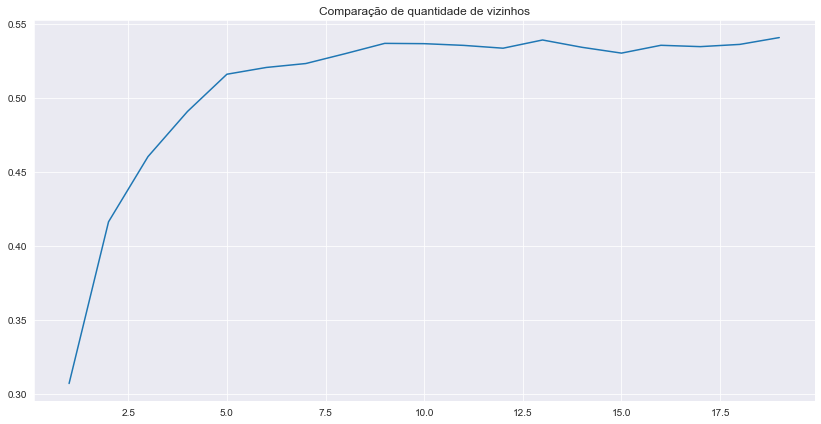

In [71]:
# compute usando KNN com diferentes neighbors
compute_results = []
for n in range(1,20):
    compute_results.append(compute_regression(X, y, KNeighborsRegressor(n_neighbors=n), True, False))

plt.figure(figsize=PLOT_WIDE)
sns.lineplot(None, x=range(1,20), y=compute_results) 
plt.title("Comparação de quantidade de vizinhos")
plt.show()

In [ ]:
compute_regression(X, y, LinearRegression(), True)
compute_regression(X, y, DecisionTreeRegressor(), True)